In [ ]:
import sys
from pathlib import Path
import datetime as dt
import numpy as np 
import pandas as pd
import json
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score,  train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

ML_LOC = PROJPATH / "data/ML_2024"

#### Let's start with Nenana (or another location)

In [ ]:
location = "Yukon River at Russian Mission"
df = pd.read_csv(ML_LOC / f"DF/DF_{location.replace(' ', '_')}", index_col=0)
df.rename(columns={'t2m': 't2m_M', 'ssr': 'ssr_M', 'sd': 'sd_M'}, inplace=True)
Xy = df.loc[1980:2023, :].dropna()
# Xy.reset_index(inplace=True, names='year')
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
X_2024 = df.iloc[-1, :-1]
# X_2024 = df.reset_index(names='year').iloc[-1, :-1]

#### Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
X.columns

Index(['AO_DJ', 'AO_FM', 'EP-NP_DJ', 'EP-NP_FM', 'PNA_DJ', 'PNA_FM',
       'Nino1+2_DJ', 'Nino1+2_FM', 'Nino4_DJ', 'Nino4_FM', 'NPI_anom_FM',
       'NAO_DJ', 'NAO_FM', 'EA_DJ', 'EA_FM', 'WP_DJ', 'WP_FM', 'EA-WR_DJ',
       'EA-WR_FM', 'SCA_DJ', 'SCA_FM', 'POL_DJ', 'POL_FM',
       'seaice_ber_anom_DJ', 'seaice_ber_anom_FM', 'seaice_chuk_anom_DJ',
       'seaice_chuk_anom_FM', 'NenanaIceThick', 't2m_M', 'ssr_M', 'sd_M'],
      dtype='object')

In [ ]:

clf = ExtraTreesRegressor(n_estimators=200, random_state=42)
clf = clf.fit(X, y)
clf.feature_importances_
selector = SelectFromModel(clf, prefit=True)
X_new = X[X.columns[selector.get_support()]]
X_new

,AO_DJ,Nino1+2_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,seaice_chuk_anom_FM
1981,-0.087,-0.950,-0.080,-0.170,0.315,0.990,-6019.920
1984,0.545,-0.090,-0.830,-0.785,-0.620,-0.150,-29958.123
1985,-1.180,-0.590,-0.795,-0.860,-0.350,-1.405,-1291.347
1986,-1.258,-0.190,-0.245,-0.195,-0.130,-0.020,2074.965
1987,-0.544,0.795,0.310,0.485,-0.375,-0.545,4041.550
1988,-0.135,0.345,0.705,0.295,-0.215,0.730,11798.344
1989,2.393,-0.525,-1.745,-1.345,-0.200,0.165,-45284.596
1990,0.178,-0.440,0.020,0.345,1.430,-0.645,12665.613
1991,1.000,-0.520,0.615,0.440,0.425,0.550,7629.881
1992,1.082,0.650,0.715,0.765,-0.135,1.035,18098.790


In [ ]:
X_new.corrwith(y)

AO_DJ                 -0.356329
Nino1+2_DJ            -0.531190
Nino4_DJ              -0.492446
Nino4_FM              -0.491712
EA_FM                 -0.351084
POL_DJ                -0.072913
seaice_chuk_anom_FM    0.257235
dtype: float64

Straight CV

In [ ]:
saveplots = True
summary = {}
summary['location'] = location
summary['predictors'] = list(X_new.columns)

In [ ]:
X_new

,AO_DJ,Nino1+2_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,seaice_chuk_anom_FM
1981,-0.087,-0.950,-0.080,-0.170,0.315,0.990,-6019.920
1984,0.545,-0.090,-0.830,-0.785,-0.620,-0.150,-29958.123
1985,-1.180,-0.590,-0.795,-0.860,-0.350,-1.405,-1291.347
1986,-1.258,-0.190,-0.245,-0.195,-0.130,-0.020,2074.965
1987,-0.544,0.795,0.310,0.485,-0.375,-0.545,4041.550
1988,-0.135,0.345,0.705,0.295,-0.215,0.730,11798.344
1989,2.393,-0.525,-1.745,-1.345,-0.200,0.165,-45284.596
1990,0.178,-0.440,0.020,0.345,1.430,-0.645,12665.613
1991,1.000,-0.520,0.615,0.440,0.425,0.550,7629.881
1992,1.082,0.650,0.715,0.765,-0.135,1.035,18098.790


In [ ]:
# load model 
modeldir = ML_LOC / 'models'
filename = f'{location}_joblib_model.sav'
best_model = joblib.load(modeldir / filename)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/chris/Projects/2023_Riverice/data/ML_2024/models/Yukon River at Dawson_joblib_model.sav'

... or calculate it 

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=43)
model = GradientBoostingRegressor(random_state=40)
    # define search space
space = {
        'min_samples_leaf': list(range(3, 7)),
        # 'min_samples_leaf': [4],
        # 'min_samples_split': [3],
        # 'max_depth': [ 4],
        'min_samples_split': [2, 3],
        'max_depth': [2, 3, 4],
        'n_estimators': [5000],
        'learning_rate': [0.02, 0.015, 0.01, 0.001],
        'subsample': [0.5],
    }
# define search
search = GridSearchCV(model, space, cv=cv_inner, scoring='neg_mean_squared_error', verbose=1, 
            refit=True, n_jobs=6)
# execute search
grid_result = search.fit(X, y)
# get the best performing model fit on the whole training set
best_model = grid_result.best_estimator_
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev}, {param}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


-47.504126769008806, 12.73657406811859, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 5000, 'subsample': 0.5}
-47.504126769008806, 12.73657406811859, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 5000, 'subsample': 0.5}
-45.88366359714291, 14.101906175975794, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5000, 'subsample': 0.5}
-45.88366359714291, 14.101906175975794, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 5000, 'subsample': 0.5}
-46.95601249485828, 17.989341855701277, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 5000, 'subsample': 0.5}
-46.95601249485828, 17.989341855701277, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 5000, 'subsample': 0.5

In [ ]:
grid_result.cv_results_['mean_test_score'][grid_result.best_index_]

-43.21734837320503

In [ ]:
best_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.015,
 'loss': 'squared_error',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5000,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
summary['modelparams'] = best_model.get_params()
summary['rms_cv'] = np.sqrt(-grid_result.cv_results_['mean_test_score'][grid_result.best_index_])
summary['rms_std_cv'] = np.sqrt(grid_result.cv_results_['std_test_score'][grid_result.best_index_])

The mean squared error (MSE) on train set: 0.9037
The mean squared error (MSE) on test set: 43.5406
The score for this training set is 0.9843
The validation score for this test set is -0.0088
Pearson score on training set: 0.9931
Pearson score on test set: 0.3795



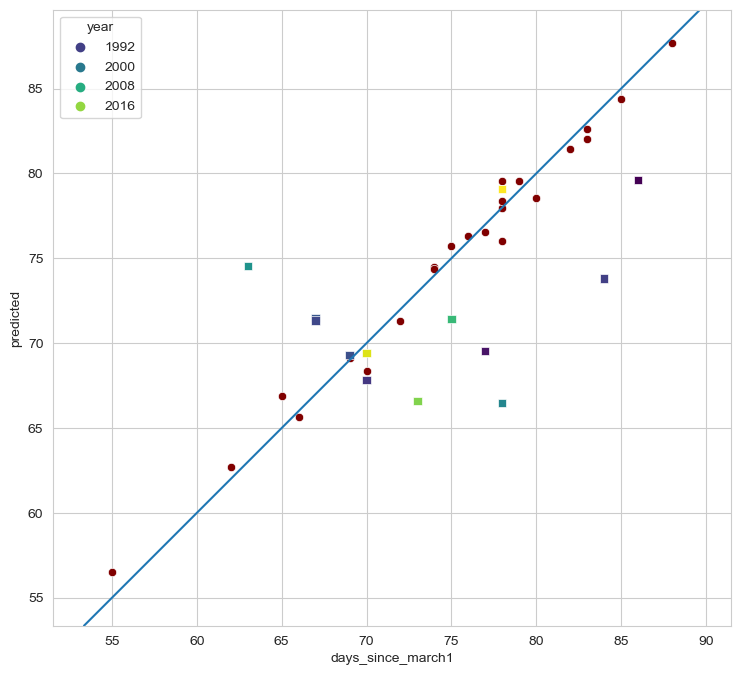

In [ ]:
random_seed = 2023
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=random_seed)

params_gb = {
        'min_samples_leaf': 4,
        'min_samples_split': 3,
        'max_depth': 4,
        # 'n_estimators': [250, 200, 150, 100],
        'n_estimators': 5000,
        'learning_rate': 0.001,
        'subsample': 0.5,
    'random_state': random_seed, 
}
model1 = GradientBoostingRegressor(**params_gb)
model2 = RandomForestRegressor(random_state=random_seed)
model2 = best_model
model3 = ExtraTreesRegressor(n_estimators=200)
# define search
model = VotingRegressor(estimators=[('gb', model1), ('rf', model2), ('lr', model3)])
model = model2
# execute search
result = model.fit(X_train, y_train)
# get the best performing model fit on the whole training set
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True)
# sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
# sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
# sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
# sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='maroon', ax=ax)
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, hue='year', marker='s', palette='viridis', ax=ax)
lims = ax.get_xlim()
ax.set_ylim(lims)
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]])
ax.set_aspect('equal')
plt.show(fig)
if saveplots:
    outdir = ML_LOC / "overfitting_tests"
    fn = f"{location.replace(' ', '_')}_overfit.png"
    fig.savefig(outdir / fn, bbox_inches='tight')

In [ ]:
model.score(X_new, y)

0.6999787093350434

In [ ]:
model.score(X_train, y_train)

0.9843432005496594

In [ ]:
model.score(X_test, y_test)

-0.0088233411670402

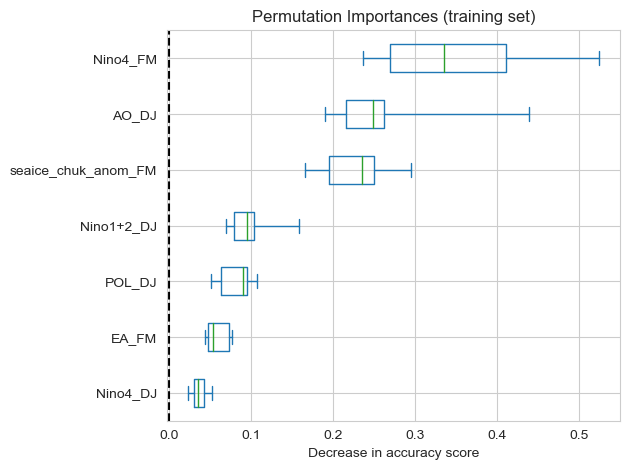

In [ ]:
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (training set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_train.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

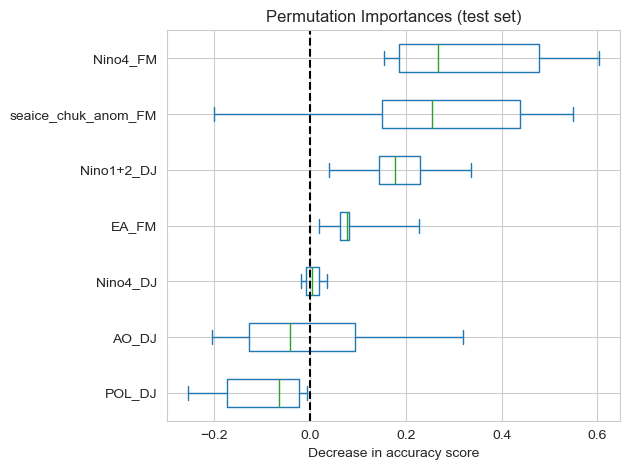

In [ ]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_test.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
sns.set_style('whitegrid')

The mean squared error (MSE) on train set: 1.6403
The mean squared error (MSE) on test set: 39.9832
The score for this training set is 0.9714
The validation score for this test set is -0.0423
Pearson score on training set: 0.9871
Pearson score on test set: 0.6598



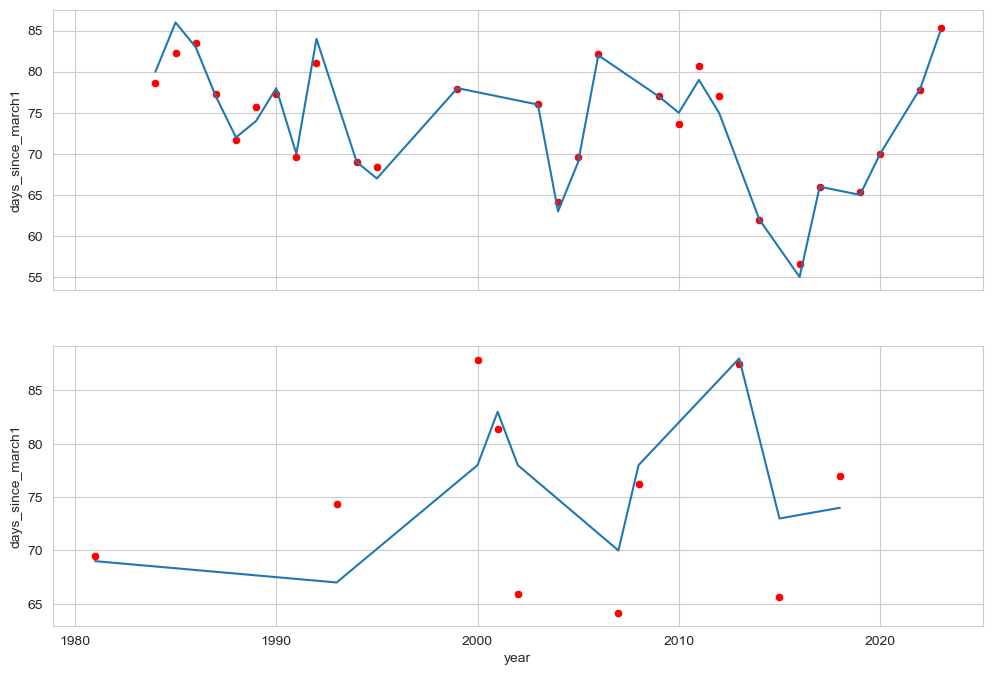

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)
model = best_model

model.fit(X_train, y_train)
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='blue', ax=ax)
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, color='red', ax=ax)
# ax.set_box_aspect(1)
plt.show(fig)

In [ ]:
X_test

,AO_DJ,Nino1+2_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,seaice_chuk_anom_FM
2002,0.029,-0.900,0.260,0.355,1.030,-0.075,-372.565
2001,-1.657,-0.795,-0.920,-0.765,0.420,0.025,5114.936
1993,2.561,-0.055,0.145,0.075,-0.925,0.540,10468.586
2013,-1.179,-0.765,-0.010,-0.280,-0.050,-1.345,10867.012
2008,0.820,-1.070,-1.285,-1.465,0.315,-0.415,16630.637
2007,2.158,0.685,0.785,0.400,0.945,-0.170,-13810.704
1981,-0.087,-0.950,-0.080,-0.170,0.315,0.990,-6019.920
2000,1.156,-0.700,-1.345,-1.450,-0.135,-0.675,9792.133
2018,-0.170,-1.270,-0.480,-0.285,-1.000,0.030,-22897.597
2015,0.753,0.125,0.755,0.885,0.580,0.275,-5813.891


In [ ]:
best_model.fit(X_new, y)
prediction = best_model.predict(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
since_date = dt.datetime.strptime('202403011200', "%Y%m%d%H%M")
preddate = (since_date + dt.timedelta(days=prediction.item())).date().strftime("%Y-%m-%d")

summary['prediction_2024'] = prediction.item()
summary['pred_date_2024'] = preddate

preddate



# ru.dayssince2date(prediction.item())

'2024-05-06'

In [ ]:
summary

{'location': 'Yukon River at Russian Mission',
 'predictors': ['AO_DJ',
  'Nino1+2_DJ',
  'Nino4_DJ',
  'Nino4_FM',
  'EA_FM',
  'POL_DJ',
  'seaice_chuk_anom_FM'],
 'modelparams': {'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.015,
  'loss': 'squared_error',
  'max_depth': 2,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 6,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 5000,
  'n_iter_no_change': None,
  'random_state': 40,
  'subsample': 0.5,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 0,
  'warm_start': False},
 'rms_cv': 6.5739902930567995,
 'rms_std_cv': 3.8901613794111847,
 'prediction_2024': 66.16060676423244,
 'pred_date_2024': '2024-05-06'}

### Shaply analysis

In [ ]:
import shap

In [ ]:
X_sample = shap.utils.sample(X_new, 50)

In [ ]:
X_test

,AO_DJ,Nino1+2_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,seaice_chuk_anom_FM
2002,0.029,-0.900,0.260,0.355,1.030,-0.075,-372.565
2001,-1.657,-0.795,-0.920,-0.765,0.420,0.025,5114.936
1993,2.561,-0.055,0.145,0.075,-0.925,0.540,10468.586
2013,-1.179,-0.765,-0.010,-0.280,-0.050,-1.345,10867.012
2008,0.820,-1.070,-1.285,-1.465,0.315,-0.415,16630.637
2007,2.158,0.685,0.785,0.400,0.945,-0.170,-13810.704
1981,-0.087,-0.950,-0.080,-0.170,0.315,0.990,-6019.920
2000,1.156,-0.700,-1.345,-1.450,-0.135,-0.675,9792.133
2018,-0.170,-1.270,-0.480,-0.285,-1.000,0.030,-22897.597
2015,0.753,0.125,0.755,0.885,0.580,0.275,-5813.891


In [ ]:
explainer = shap.Explainer(best_model.predict, X_new)
shap_values = explainer(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
shap_values_all = explainer(X_new)
explainer2 = shap.Explainer(best_model.predict, X_test)
shap_values_test = explainer2(X_test)
sample_ind = 20

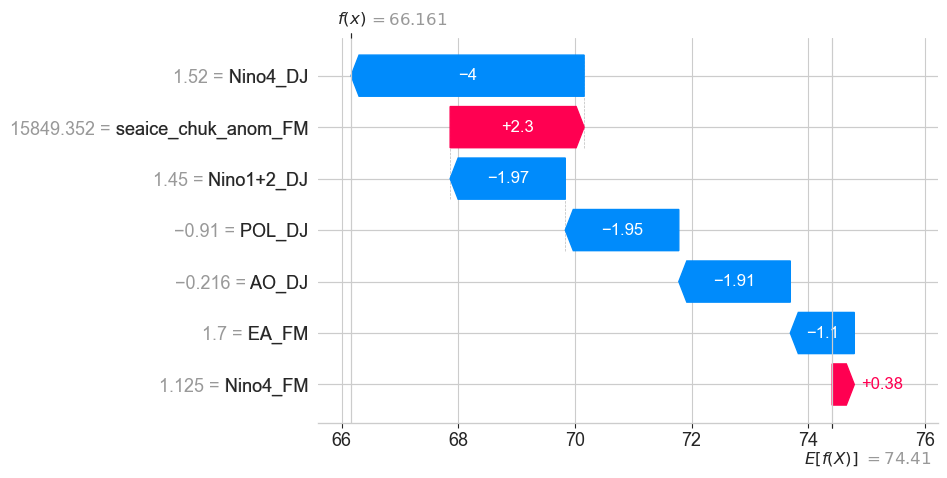

In [ ]:
ax = shap.plots.waterfall(shap_values[0], max_display=20, show=False)
# ax.set_title(f"2024, {location}")
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_waterfall_2024.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

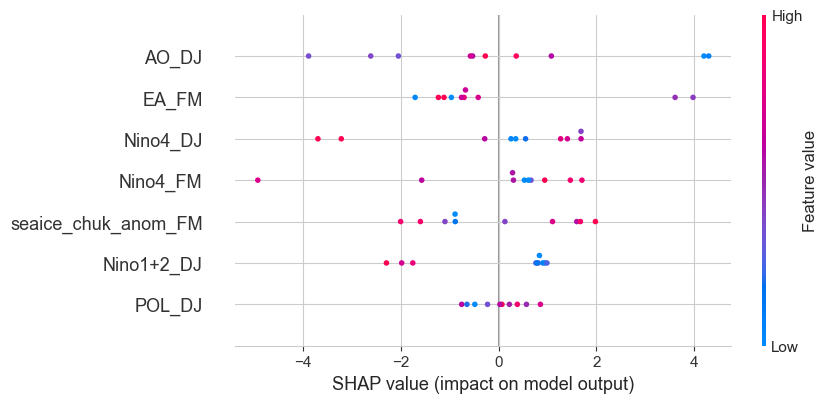

In [ ]:
shap.plots.beeswarm(shap_values_test, max_display=25)

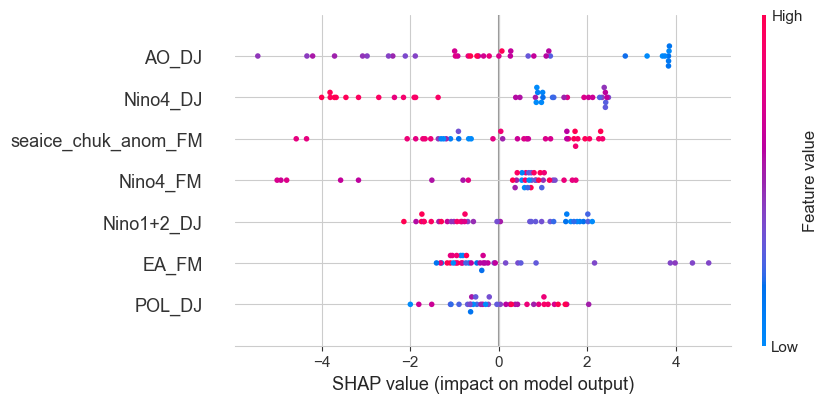

In [ ]:
shap.plots.beeswarm(shap_values_all, max_display=25, show=False)

if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_beehive.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
if saveplots:

    modeldir = ML_LOC / 'models'
    filename = f"{location.replace(' ', '_')}_joblib_model.sav"
    joblib.dump(model, modeldir / filename)
    summarydir =ML_LOC / 'model_eval'
    summaryfn = f"{location.replace(' ', '_')}_modelsummary.json"
    with open(summarydir / summaryfn, 'w' ) as dst: 
        json.dump(summary, dst, indent=2)
